# MS AABD - devoir python 

Une compagnie d’assurance souhaite construire un score d’appétence pour une « garantie accident de la vie », dans un contexte de vente croisée
Les données sont issues de diverses filiales du groupe : autres produits détenus, éléments socio-démographiques, habitudes de vie ou de consommation ainsi que la sinistralité observée.

L’appétence est désignée par la colonne « target », binaire. Il faut donc prédire les lignes avec une target à 1.
La performance sera mesurée par le lift : % de client appétent

Le livrable comprend donc :
    - Un ppt
    - Un Notebook

Nous avons donc un fichier "projetdatascience.rda" dans lequel il y a 2 jeux de données:
    - jeu d'apprentissage "projetTrain"
    - jeu de validation "projetValid"
    
Le notebook ci-après est un début de réponse à cette question.


# -1) Imports

In [1]:
%matplotlib inline
import pandas as pd
import os
import sys
import numpy as np
from datetime import datetime
from collections import defaultdict
import itertools

In [2]:
import scipy.stats as stats
import pylab
import matplotlib.pyplot as plot

In [3]:
from matplotlib import pyplot as plt

In [4]:
import rpy2.robjects as robjects
import pandas.rpy.common as com

C:\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  


In [5]:
from sklearn import feature_selection, cross_validation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

C:\Anaconda\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 0) Useful functions

In [6]:
def print_time():
    """
    Affiche et retourne l'heure de la machine.
    Utilisé pour mesurer le temps d'execution du classifieur.
    """
    import time
    import datetime
    t = datetime.datetime.now().time()
    #print t.isoformat()[:8]
    return time.time()

In [7]:
def draw_confusion_matrix(y_test, predictions, title):
    """
    Créé et affiche la matrice de confusion des données de Y_test et de celles sur lesquelles on a fait la prédiction.
    Permet d'évaluer la qualité de la classification souhaitée.
    Plus les valeurs diagonales sont élevées, plus le classifieur prédit correctement.
    """
    from sklearn.metrics import confusion_matrix,accuracy_score
    import matplotlib.pyplot as plt
    cm    = confusion_matrix(y_test, predictions)
    accur = accuracy_score  (y_test, predictions)
    
    plt.matshow  (cm)
    plt.ylabel   ('True Label')
    plt.xlabel   ('Predicted Label')
    plt.suptitle ('Confusion matrix (Accuracy of %.2f) for [%s]'%(accur,title))
    plt.colorbar ()
    plt.show     ()

In [8]:
def draw_roc_curve(fitted_c, x_test, y_test, title):
    """
    Créé et affiche la courbe ROC des données de test X et Y selon un classifieur (SVM, KNN, RF).
    Permet de représenter l'évolution de la vitesse d'apprentissage du classifieur.
    Taux de vrais-positifs en fonction du taux de faux-négatif.
    Plus l'aire sous la courbe est grande, plus le classifieur est idéal.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    c                                        = fitted_c
    probas                                   = c.predict_proba(x_test)
    false_positive_rate, recall_, thresholds = roc_curve(y_test, probas[:,1])
    roc_auc                                  = auc(false_positive_rate, recall_)
    
    plt.title  ('ROC %.2f %s'%(roc_auc, title))
    plt.legend (loc="lower right")
    plt.plot   ([0,1],[0,1], "r--")
    plt.plot   (false_positive_rate, recall_, 'b', label='AUC = %.2f'%roc_auc)
    plt.xlim   ([0.0,1.1])
    plt.ylim   ([0.0,1.1])
    plt.ylabel ('Recall')
    plt.xlabel ('Fall-out')
    plt.show()

# 1) Chargement des données

In [9]:
robj = robjects.r.load('projetdatascience.rda')
print(robj)

[1] "projetTrain" "projetValid"



In [10]:
projetTrain = com.load_data(robj[0])
projetTrain

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,target
1,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,1
2,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,0
3,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,1
4,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,1
5,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,1
6,11,1,A8,10,0.166194,2,3,1,0.373134,0.581818,...,0,0,0,0,0,0,0,0,0,1
7,14,1,D2,26,0.076923,2,3,1,0.611940,0.781818,...,0,0,0,0,0,0,0,0,0,0
8,15,1,D3,26,0.230769,2,3,1,0.522388,0.618182,...,0,0,0,0,0,0,0,0,0,1
9,16,1,E1,21,0.076923,2,3,1,0.552239,0.600000,...,0,0,0,0,0,0,0,0,0,0
10,18,1,D4,26,0.230769,2,3,1,0.298507,0.690909,...,0,0,0,0,0,0,0,0,0,0


In [11]:
projetValid = com.load_data(robj[1])
projetValid

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
1,70893,1,A8,26,0.076923,2,3,1,0.776119,0.654545,...,0,0,0,0,0,0,0,0,0,0
2,20997,1,D2,26,0.076923,2,3,1,0.552239,0.818182,...,0,0,0,0,0,0,0,0,0,1
3,29427,1,D3,10,0.230769,2,3,1,0.208955,0.636364,...,0,0,0,0,0,0,0,0,0,0
4,45161,1,A1,26,0.256410,2,3,1,0.328358,0.745455,...,0,0,0,0,0,0,0,0,0,0
5,71802,1,D3,26,0.282051,2,3,1,0.686567,0.781818,...,0,0,0,1,0,0,0,0,0,0
6,15895,1,D4,10,0.230769,2,3,1,0.373134,0.600000,...,0,0,0,0,0,0,0,0,0,0
7,71014,1,D1,26,0.230769,2,1,1,0.373134,0.763636,...,0,0,0,0,0,0,0,0,0,0
8,74730,1,D3,26,0.230769,2,3,1,0.358209,0.800000,...,0,0,0,0,0,0,0,0,0,0
9,52094,1,D4,10,0.076923,2,3,1,0.447761,0.581818,...,0,0,0,0,0,0,0,0,0,0
10,49602,2,D4,26,0.230769,2,3,1,0.119403,0.709091,...,0,0,0,0,0,0,0,0,0,0


# 2) Visualisation de la variable target

In [12]:
dataSerie = pd.Series(projetTrain.target)

In [13]:
dataSerie.sort()
x = dataSerie.value_counts()

C:\Anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  """Entry point for launching an IPython kernel.


In [14]:
x = x.sort_index()

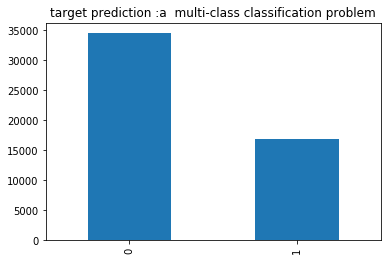

In [15]:
title="target prediction :a  multi-class classification problem"
x.plot(kind="bar", title=title)

# Le problème de répartition dans les classes de target semble mieux appréhendé, cependant il est encore un peu présent

# 3) Remplissage des données manquantes par la moyenne mean

In [16]:
class pdStandardScaler:
    #Applies the sklearn StandardScaler to pandas dataframes
    def __init__(self):
        from sklearn.preprocessing import StandardScaler
        self.StandardScaler = StandardScaler()
    def fit(self, df):
        self.StandardScaler.fit(df)
    def transform(self, df):
        df = pd.DataFrame(self.StandardScaler.transform(df), columns=df.columns)
        return df
    def fit_transform(self, df):
        df = pd.DataFrame(self.StandardScaler.fit_transform(df), columns=df.columns)
        return df

In [17]:
def getDummiesInplace(columnList, train, test = None):
    #Takes in a list of column names and one or two pandas dataframes
    #One-hot encodes all indicated columns inplace
    columns = []
    
    if test is not None:
        df = pd.concat([train,test], axis= 0)
    else:
        df = train
        
    for columnName in df.columns:
        index = df.columns.get_loc(columnName)
        if columnName in columnList:
            dummies = pd.get_dummies(df.ix[:,index], prefix = columnName, prefix_sep = ".")
            columns.append(dummies)
        else:
            columns.append(df.ix[:,index])
    df = pd.concat(columns, axis = 1)
    
    if test is not None:
        train = df[:train.shape[0]]
        test = df[train.shape[0]:]
        return train, test
    else:
        train = df
        return train

In [18]:
def pdFillNAN(df, strategy = "mean"):
    #Fills empty values with either the mean value of each feature, or an indicated number
    if strategy == "mean":
        return df.fillna(df.mean())
    elif type(strategy) == int:
        return df.fillna(strategy)

In [19]:
def make_dataset(useDummies = True, fillNANStrategy = "mean", useNormalization = True):
    train = projetTrain
    test = projetValid
    
    labels = train["target"]
    train.drop(labels = "Id", axis = 1, inplace = True)
    train.drop(labels = "target", axis = 1, inplace = True)
    test.drop(labels = "Id", axis = 1, inplace = True)
    
    categoricalVariables = ["Product_Info_1", "Product_Info_2", "Product_Info_3", "Product_Info_5", "Product_Info_6", "Product_Info_7", "Employment_Info_2", "Employment_Info_3", "Employment_Info_5", "InsuredInfo_1", "InsuredInfo_2", "InsuredInfo_3", "InsuredInfo_4", "InsuredInfo_5", "InsuredInfo_6", "InsuredInfo_7", "Insurance_History_1", "Insurance_History_2", "Insurance_History_3", "Insurance_History_4", "Insurance_History_7", "Insurance_History_8", "Insurance_History_9", "Family_Hist_1", "Medical_History_2", "Medical_History_3", "Medical_History_4", "Medical_History_5", "Medical_History_6", "Medical_History_7", "Medical_History_8", "Medical_History_9", "Medical_History_10", "Medical_History_11", "Medical_History_12", "Medical_History_13", "Medical_History_14", "Medical_History_16", "Medical_History_17", "Medical_History_18", "Medical_History_19", "Medical_History_20", "Medical_History_21", "Medical_History_22", "Medical_History_23", "Medical_History_25", "Medical_History_26", "Medical_History_27", "Medical_History_28", "Medical_History_29", "Medical_History_30", "Medical_History_31", "Medical_History_33", "Medical_History_34", "Medical_History_35", "Medical_History_36", "Medical_History_37", "Medical_History_38", "Medical_History_39", "Medical_History_40", "Medical_History_41"]

    if useDummies == True:
        print ("Generation des null...")
        train, test = getDummiesInplace(categoricalVariables, train, test)
    
    if fillNANStrategy is not None:
        print ("Remplissage des valeurs manquantes...")
        train = pdFillNAN(train, fillNANStrategy)
        test = pdFillNAN(test, fillNANStrategy)

    if useNormalization == True:
        print ("Mise a l echelle...")
        scaler = pdStandardScaler()
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
    
    return train, test, labels

In [20]:
print ("Creation des donnees...")
train, test, labels = make_dataset(useDummies = True, fillNANStrategy = "mean", useNormalization = True)

Creation des donnees...
Generation des null...
Remplissage des valeurs manquantes...
Mise a l echelle...


# 4) GridSearch

In [21]:
def RandomForest_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur Random Forest
    """
    import sys, pickle
    from sklearn.ensemble          import RandomForestClassifier
    from sklearn                   import grid_search
    from sklearn.metrics           import make_scorer
    from sklearn.preprocessing     import label_binarize
    from sklearn.multiclass        import OneVsRestClassifier
    #grid search :

    parameters = {  "n_estimators"         : [ 300], 
                    "min_samples_leaf"     : [  5 ],
                    "criterion"            : ["gini"],#["gini", "entropy"]         ,
                    "max_features"         : ["auto"]      ,
                    "max_depth"            : [None]         , 
                    "n_jobs"               : [ -1]             ,  
                    "class_weight"         : [None]         ,
                    "warm_start"           : [False]           }

    
    grid_type = "RandomForestClassifier"
    
    print("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search 
    """
    
    grid         = grid_search.GridSearchCV(RandomForestClassifier(), parameters, verbose=0, scoring='f1_weighted')
    
    try :grid.fit(df, Y)
    except Exception as e : print("[%s - 2] : %s"%(grid_type,e))
    
    print(" best_score_ %s with =  %s "%( grid.best_score_,  grid.best_estimator_ )) ; sys.stdout.flush()    
    return grid.best_estimator_

In [22]:
def svm_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du classifieur Support Vector Machine
    Notamment : 'C', 'kernel' et 'gamma'
    """
    import sys
    from sklearn                   import grid_search
    from sklearn.svm               import SVC
    import pickle
    parameters = {  "C"              : [1.0],#, 0.5, 0.1, 2]                , 
                    "kernel"         : ['rbf'],#, 'poly', 'sigmoid']        ,
                    "degree"         : [2],#, 3, 4,5,6]                     , 
                    "gamma"          : [0.01],#, 0.1, 0.001, 0.5]           , 
                    "coef0"          : [0.0]                             , 
                    "shrinking"      : [True]                            , 
                    "probability"    : [True]                            , 
                    "tol"            : [0.001]                           , 
                    "cache_size"     : [10]                              , 
                    "class_weight"   : [None]                            , 
                    "verbose"        : [False]                           , 
                    "max_iter"       : [-1]                              , 
                    "random_state"   : [None]                            }
    
    
    print("-"*30, "\n svm_grid_search"); sys.stdout.flush()
    
    """
        Search Grid
    """
    grid    = grid_search.GridSearchCV(SVC(), parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : print("[svm_grid_search - 2] : %s"%e); print("x_train, y_train : ", x_train, y_train) 

    print(" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ )); sys.stdout.flush()    
    return grid.best_estimator_

In [23]:
def clf_grid_search(df, Y):
    """
    Réglage des hyper-paramètres du Classifier Gradient Boosting
    """
    import sys
    from sklearn                   import grid_search
    from sklearn.neighbors         import KNeighborsClassifier
    from sklearn import ensemble
    from sklearn import datasets
    from sklearn.utils import shuffle
    from sklearn.metrics import mean_squared_error
    from sklearn.datasets import make_hastie_10_2
    from sklearn.ensemble import GradientBoostingClassifier
    
    import pickle

    parameters = {'n_estimators': [230 ]                       ,
                  'max_depth':  [15]                        ,
                  'min_samples_split':  [2]                    ,
                  'learning_rate':  [0.5]                             }
    
    grid_type = "clf_grid_search"
    print("-"*30, "\n %s"%grid_type); sys.stdout.flush()
    """
        Search Grid
    """
    print(parameters);sys.stdout.flush()
    
    grid = grid_search.GridSearchCV(GradientBoostingClassifier(),  parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : print("Error : [%s - 2] : %s"%(grid_type,e)); return -1
    print(" best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ )); sys.stdout.flush()    
    return grid

# 5) Application grid search

## 5.1) Variable: target

In [24]:
from sklearn.cross_validation import train_test_split

In [25]:
# Split des données originales en données d'entrainement et de test
# La classification se fait en fonction de la variable 'target' 
# 75% de données de d'entrainement
# 25% de données de test
train,X_test,labels,y_test = train_test_split(train,labels, test_size=0.2, random_state=42)

### 5.1.1) SVM

In [26]:
nb_lignes = 2000
start_time = print_time()

# Apprentissage du classifieur SVM sur X_train et Y_train (<nb_lignes> données)
svm = svm_grid_search(train[:nb_lignes], labels[:nb_lignes].get_values())

end_time = print_time()
print("\nDuration time :", end_time - start_time)
# REMARQUES :
# L'utilisation du classifieur SVM ne semble toujours pas très approprié pour faire des prédictions sur nos données.
# D'autre part, le temps nécessaire pour faire un apprentissage pour entrainer le classifieur svm est toujours trop important
# au vue du nombre de données que l'on lui fournit.

C:\Anaconda\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


------------------------------ 
 svm_grid_search
 best_score_ = 0.69 with =  SVC(C=1.0, cache_size=10, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

Duration time : 82.15969967842102


C:\Anaconda\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


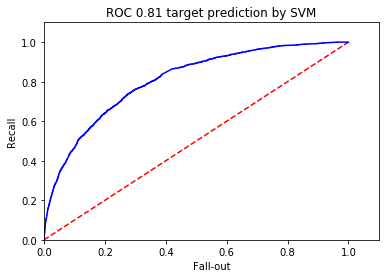

In [27]:
# Courbe ROC des données de test X et Y selon le classifieur SVM 
# Au mieux, le classifieur à une performance de 0.69 pour la prédiction du target
draw_roc_curve(svm, X_test, y_test, "target prediction by SVM")

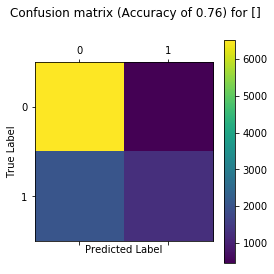

In [28]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
# La prédiction du modèle étant de 0.73, au mieux, n'est pas satisfaisant.
# Un nombre trop important de Faux Positif est présent.
# Le classifieur SVM ne semble toujours pas adapté pour effectuer une prédiction sur nos données.
draw_confusion_matrix(y_test, svm.predict(X_test), "")

C:\Anaconda\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 32 335 346 387 421 432 463 468 484 505 524 525 543 547 548 566 600 636
 642 662 736 787 793 797 802 808 819 830 836 850 859 892] are constant.
  UserWarning)
C:\Anaconda\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


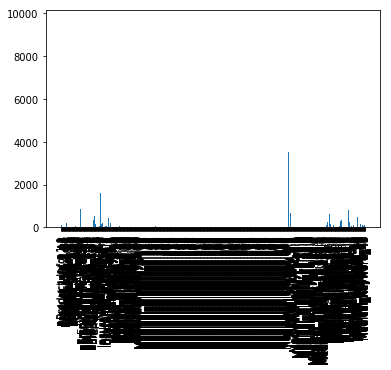

In [29]:
selector = feature_selection.SelectKBest(feature_selection.f_classif, k=40)
selector.fit(train, labels)

scores = selector.scores_
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(train.columns.values)), list(train.columns.values), rotation = 'vertical')
plt.show()

## 5.1.2) RandomForest

In [30]:
nb_lignes = 2000
start_time = print_time()

# Apprentissage du classifieur RF sur X_train et Y_train (<nb_lignes> données)
rf = RandomForest_grid_search(train[:nb_lignes], labels[:nb_lignes])

end_time = print_time()
print("\nDuration time :", end_time - start_time)

# REMARQUES :
# L'utilisation du classifieur RF semble approprié pour faire une prédiction sur les données que l'on possède.


------------------------------ 
 RandomForestClassifier
 best_score_ 0.7851590088680984 with =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 

Duration time : 4.444254159927368


C:\Anaconda\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


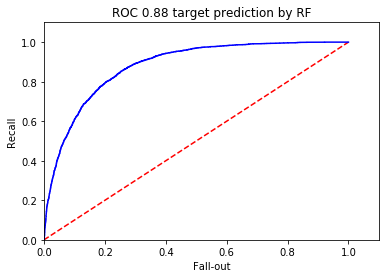

In [31]:
# Courbe ROC des données de test X et Y selon le classifieur RF
# Au mieux, le classifieur à une performance de 0.78 pour la prédiction du target
draw_roc_curve(rf, X_test, y_test, "target prediction by RF")

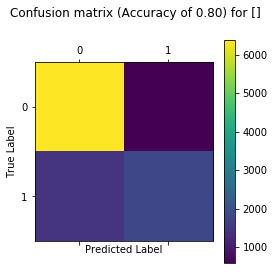

In [32]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
# La prédiction du modèle étant de 0.80, au mieux, commence à être correct.
# Un grand nombre de Vrais Positifs et Vrais Négatifs sont présents.
draw_confusion_matrix(y_test, rf.predict(X_test), "")

C:\Anaconda\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 32 335 346 387 421 432 463 468 484 505 524 525 543 547 548 566 600 636
 642 662 736 787 793 797 802 808 819 830 836 850 859 892] are constant.
  UserWarning)
C:\Anaconda\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


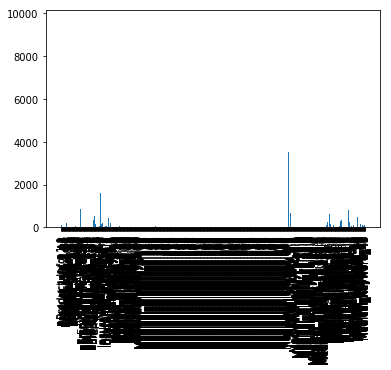

In [33]:
selector = feature_selection.SelectKBest(feature_selection.f_classif, k=40)
selector.fit(train, labels)

scores = selector.scores_
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(train.columns.values)), list(train.columns.values), rotation = 'vertical')
plt.show()

## 5.1.3) CLF

In [34]:
nb_ligne = 2000
start_time = print_time()

clf = clf_grid_search(train[:nb_ligne], labels[:nb_ligne])

end_time = print_time()
print("\nDuration time :", end_time - start_time)

------------------------------ 
 clf_grid_search
{'n_estimators': [230], 'max_depth': [15], 'min_samples_split': [2], 'learning_rate': [0.5]}
 best_score_ = 0.81 with =  GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=230,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False) 

Duration time : 15.80890417098999


C:\Anaconda\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


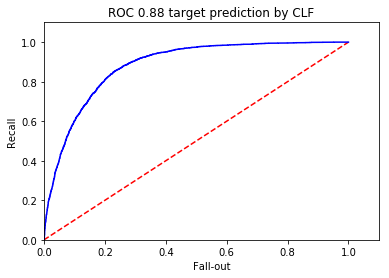

In [35]:
# Courbe ROC des données de test X et Y selon le classifieur CLF
# Au mieux, le classifieur à une performance de 0.81 pour la prédiction du target
# La classification se fait plutôt correctement au vue de la performance du classifieur
draw_roc_curve(clf, X_test, y_test, "target prediction by CLF")

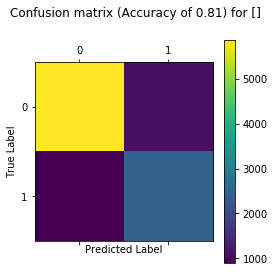

In [36]:
# Matrice de confusion des données X_test sur lesquelles on fait la prédiction et des données Y_test.
# Le classifieur CLF est  satisfaisant sur nos données
draw_confusion_matrix(y_test, clf.predict(X_test), "")

# Le Classifier Gradient Boosting semble être le meilleur modèle de prédiction que nous avons testé jusqu'ici
# La prédiction et la précision sont les plus élevées que nous avons enregistré jusqu'ici

C:\Anaconda\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [ 32 335 346 387 421 432 463 468 484 505 524 525 543 547 548 566 600 636
 642 662 736 787 793 797 802 808 819 830 836 850 859 892] are constant.
  UserWarning)
C:\Anaconda\anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


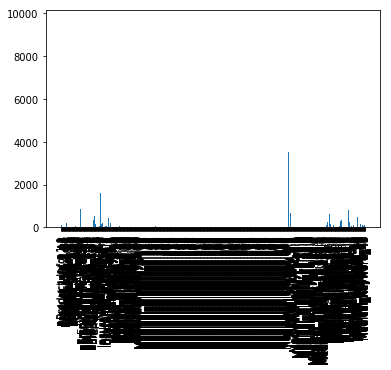

In [37]:
selector = feature_selection.SelectKBest(feature_selection.f_classif, k=40)
selector.fit(train, labels)

scores = selector.scores_
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(train.columns.values)), list(train.columns.values), rotation = 'vertical')
plt.show()

Number of 0:  27543
Number of 1:  13561


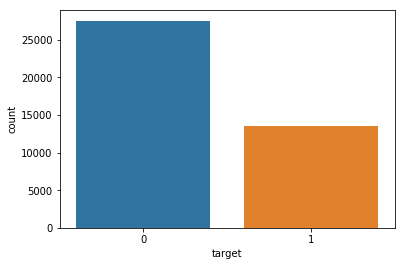

In [44]:
import seaborn as sns
ax = sns.countplot(labels,label="Count")
B, M = labels.value_counts()
print('Number of 0: ',B)
print('Number of 1: ',M)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

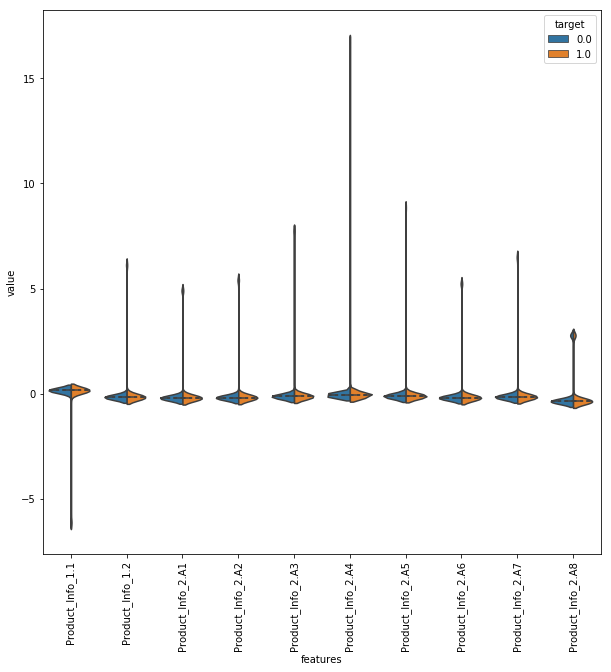

In [46]:
# les 10 premiers features
data_dia = labels
data = train
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([labels,data_n_2.iloc[:,0:10]],axis=1)
data = pd.melt(data,id_vars="target",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=data,split=True, inner="quart")
plt.xticks(rotation=90)